In [5]:
## Interactive magics
%matplotlib inline
%qtconsole --colors=linux

In [6]:
import sys
import warnings
warnings.filterwarnings('ignore')

import regex as re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import patsy as pt
from scipy import optimize

# pymc3 libraries
import pymc3 as pm
import theano as thno
import theano.tensor as T
# import pystan

# get watermark
# %install_ext https://raw.githubusercontent.com/rasbt/watermark/master/watermark.py

sns.set(style="darkgrid", palette="muted")
pd.set_option('display.mpl_style', 'default')
plt.rcParams['figure.figsize'] = 14, 6
np.random.seed(0)

In [7]:

def strip_derived_rvs(rvs):
    '''Convenience fn: remove PyMC3-generated RVs from a list'''
    ret_rvs = []
    for rv in rvs:
        if not (re.search('_log',rv.name) or re.search('_interval',rv.name)):
            ret_rvs.append(rv)
    return ret_rvs


def plot_traces_pymc(trcs, varnames=None):
    ''' Convenience fn: plot traces with overlaid means and values '''

    nrows = len(trcs.varnames)
    if varnames is not None:
        nrows = len(varnames)

    ax = pm.traceplot(trcs, varnames=varnames, figsize=(12,nrows*1.4),
                      lines={k: v['mean'] for k, v in
                             pm.df_summary(trcs,varnames=varnames).iterrows()})

    for i, mn in enumerate(pm.df_summary(trcs, varnames=varnames)['mean']):
        ax[i,0].annotate('{:.2f}'.format(mn), xy=(mn,0), xycoords='data',
                         xytext=(5,10), textcoords='offset points', rotation=90,
                         va='bottom', fontsize='large', color='#AA0022')



# Simulação

In [106]:
theta_primavera = 4 
theta_verão = 6 
theta_outono = 2
theta_inverno = 1
q = 1000

# create samples

df = pd.DataFrame({
        
        'atendimentos': np.concatenate((np.random.poisson(theta_primavera, q),
                                   np.random.poisson(theta_verão, q),
                                   np.random.poisson(theta_outono, q),
                                   np.random.poisson(theta_inverno, q))),
        'primavera': np.concatenate((np.repeat(True, q),
                                   np.repeat(False, q),
                                   np.repeat(False, q),
                                   np.repeat(False, q))),
        u'verão': np.concatenate((np.repeat(False, q),
                                   np.repeat(True, q),
                                   np.repeat(False, q),
                                   np.repeat(False, q))),
        'outono': np.concatenate((np.repeat(False, q),
                                   np.repeat(False, q),
                                   np.repeat(True, q),
                                   np.repeat(False, q))),
        'inverno': np.concatenate((np.repeat(False, q),
                                   np.repeat(False, q),
                                   np.repeat(False, q),
                                   np.repeat(True, q)))})

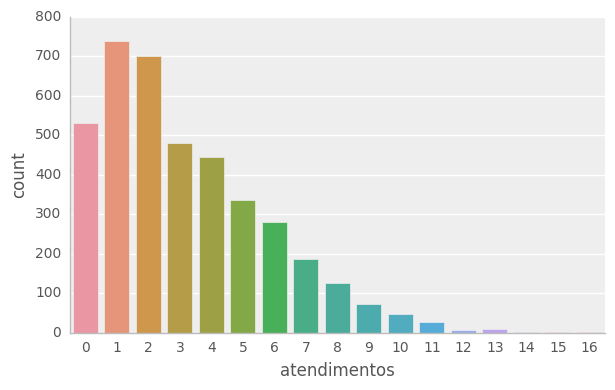

In [118]:
g = sns.factorplot(x='atendimentos', data=df,
               kind='count', size=4, aspect=1.5)

# Regressão

In [108]:
fml = 'atendimentos ~ primavera+verão+outono+inverno'  # full patsy formulation

In [109]:
(mx_en, mx_ex) = pt.dmatrices(fml, df, return_type='dataframe', NA_action='raise')


In [110]:
pd.concat((mx_ex.head(3),mx_ex.tail(3)))

,Intercept,primavera[T.True],verão[T.True],outono[T.True],inverno[T.True]
0,1.0,1.0,0.0,0.0,0.0
1,1.0,1.0,0.0,0.0,0.0
2,1.0,1.0,0.0,0.0,0.0
3997,1.0,0.0,0.0,0.0,1.0
3998,1.0,0.0,0.0,0.0,1.0
3999,1.0,0.0,0.0,0.0,1.0


In [111]:
i = 0
for i in mx_ex['Intercept']:
    if  mx_ex['Intercept'][i] == 0:
        print (i)  
        i +=1

In [112]:
with pm.Model() as mdl_fish:

    # define priors, weakly informative Normal
    b0 = pm.Normal('b0_intercept', mu=0, sd=10)
    b1 = pm.Normal('b1_primavera[T.True]', mu=0, sd=10)
    b2 = pm.Normal('b2_verão[T.True]', mu=0, sd=10)
    b3 = pm.Normal('b3_outono[T.True]', mu=0, sd=10)
    b4 = pm.Normal('b4_inverno[T.True]', mu=0, sd=10)
    # define linear model and exp link function
    theta = (b0 +
            b1 * mx_ex['primavera[T.True]'] + 
            b2 * mx_ex['verão[T.True]'] +
            b3 * mx_ex['outono[T.True]'] +
            b4 * mx_ex['inverno[T.True]']
            )

    ## Define Poisson likelihood
    y = pm.Poisson('y', mu=np.exp(theta), observed=mx_en['atendimentos'].values)

In [113]:
with mdl_fish:

    start_MAP = pm.find_MAP(fmin=optimize.fmin_powell)
    trc_fish = pm.sample(2000, start=start_MAP, njobs=3, step=pm.NUTS())

100%|██████████| 2000/2000 [10:40<00:00,  5.66it/s]


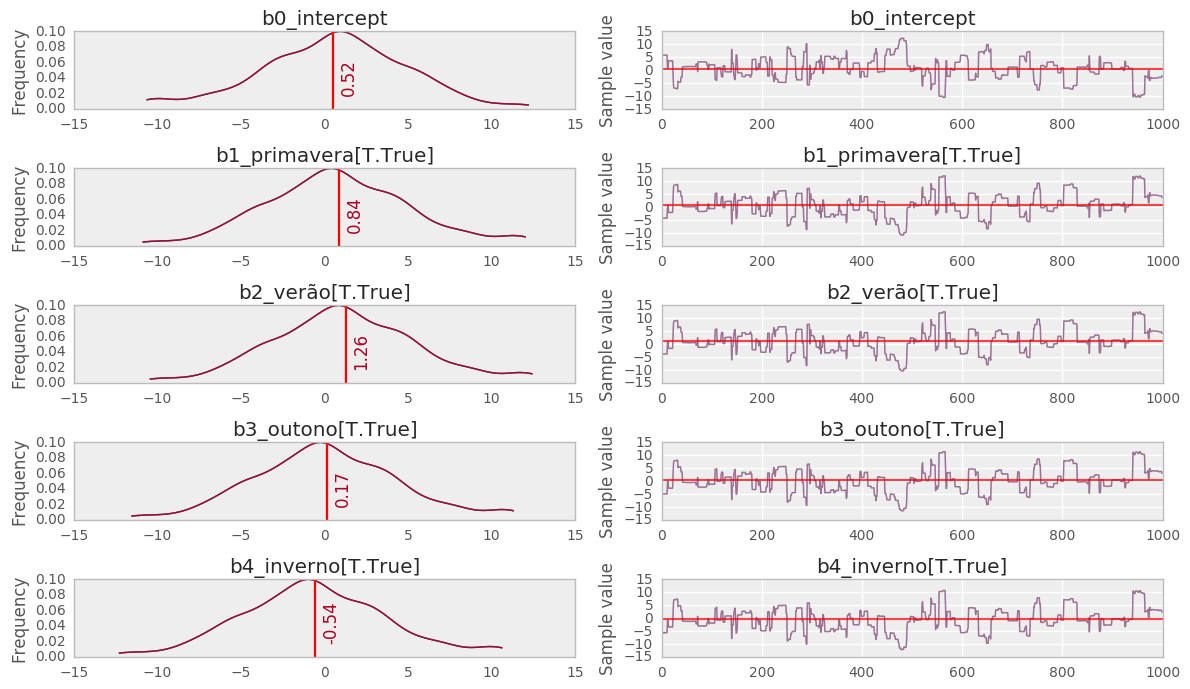

In [114]:
rvs_fish = [rv.name for rv in strip_derived_rvs(mdl_fish.unobserved_RVs)]
plot_traces_pymc(trc_fish[-1000:], varnames=rvs_fish)

In [115]:
table = np.exp(pm.df_summary(trc_fish[-1000:], varnames=rvs_fish)[['mean','hpd_2.5','hpd_97.5']])

In [116]:
table

,mean,hpd_2.5,hpd_97.5
b0_intercept,1.677900,0.000024,1811.277745
b1_primavera[T.True],2.322246,0.002148,160818.488862
b2_verão[T.True],3.521282,0.003169,239660.895783
b3_outono[T.True],1.187065,0.001097,79968.278967
b4_inverno[T.True],0.582137,0.000538,40594.043103


In [117]:
print("theta_primavera = " + str(round(table["mean"][0] *table['mean'][1])))
print("theta_verão = " + str(round(table["mean"][0] *table['mean'][2])))
print("theta_outono = " + str(round(table["mean"][0] *table['mean'][3])))
print("theta_inverno = " + str(round(table["mean"][0] *table['mean'][4])))

theta_primavera = 4.0
theta_verão = 6.0
theta_outono = 2.0
theta_inverno = 1.0
